In [1]:
import os
import sys
import re

import numpy as np
import pandas as pd
import scipy as sp
from scipy import signal

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
sys.path.insert(0, '../src')
from features import *
from utils import *
from eda import *

In [3]:
sns.set(rc={'figure.figsize':(20,5)})

In [4]:
mbit_rate = 1/125000

low_fp = '../data/240p/' 
threesixty_fp = '../data/360p/' 
med_fp = '../data/480p/'
seventwenty_fp = '../data/720p/' 
high_fp = '../data/1080p/' 

In [5]:
low_dfs = []
for file in os.listdir(low_fp):
    if file != '.ipynb_checkpoints' and file != '.DS_Store':
        low_dfs.append(pd.read_csv(low_fp+file))
    
threesixty_dfs = []
for file in os.listdir(threesixty_fp):
    if file != '.ipynb_checkpoints' and file != '.DS_Store':
        threesixty_dfs.append(pd.read_csv(threesixty_fp+file))
        
med_dfs = []
for file in os.listdir(med_fp):
    if file != '.ipynb_checkpoints' and file != '.DS_Store':
        med_dfs.append(pd.read_csv(med_fp+file))
        
seventwenty_dfs = []
for file in os.listdir(seventwenty_fp):
    if file != '.ipynb_checkpoints' and file != '.DS_Store':
        seventwenty_dfs.append(pd.read_csv(seventwenty_fp+file))
    
high_dfs = []
for file in os.listdir(high_fp):
    if file != '.ipynb_checkpoints' and file != '.DS_Store':
        high_dfs.append(pd.read_csv(high_fp+file))

In [ ]:
low_ms = []
for df in low_dfs:
    low_ms.append(convert_ms_df(df,True))
    
threesixty_ms = []
for df in threesixty_dfs:
    threesixty_ms.append(convert_ms_df(df,True))
    
med_ms = []
for df in med_dfs:
    med_ms.append(convert_ms_df(df,True))
    
seventwenty_ms = []
for df in seventwenty_dfs:
    seventwenty_ms.append(convert_ms_df(df,True))
    
high_ms = []
for df in high_dfs:
    high_ms.append(convert_ms_df(df,True))

In [ ]:
low_resamples = []
for df in low_ms:
    low_resamples.append(df.resample('500ms', on='Time').sum())
    
threesixty_resamples = []
for df in threesixty_ms:
    threesixty_resamples.append(df.resample('500ms', on='Time').sum())
    
med_resamples = []
for df in med_ms:
    med_resamples.append(df.resample('500ms', on='Time').sum())
    
seventwenty_resamples = []
for df in seventwenty_ms:
    seventwenty_resamples.append(df.resample('500ms', on='Time').sum())
    
high_resamples = []
for df in high_ms:
    high_resamples.append(df.resample('500ms', on='Time').sum())

In [ ]:
# low_resample = low_ms.resample('500ms', on='Time').sum()
# med_resample = med_ms.resample('500ms', on='Time').sum()
# high_resample = high_ms.resample('500ms', on='Time').sum()


## Aggregate Features

In [6]:
## take the aggregate features of the whole chunk; download and upload
def agg_feat(df, col):
    return [np.mean(df[col]), np.std(df[col])]

## take the ratio of upload:download packets
def pkt_ratio(df):
    ms_df = convert_ms_df(df, True)
    local = np.sum(ms_df['pkt_src'] == '1') 
    server = np.sum(ms_df['pkt_src'] == '2') 
    return local / server

## take the ratio of upload:download bytes
def bytes_ratio(df):
    local = df['1->2Bytes'].sum()
    server = df['2->1Bytes'].sum()
    return local / server

## Peak Related Aggregate Features

In [7]:
## finds the peaks with mean + 2(1) std
## run the above aggregate functions on the peaks only??

def get_peak_loc(df, col, invert=False):
  'invert arg allows you to get values not considered peaks'
  df_avg = df[col].mean()
  df_std = df[col].std()
  
  threshold = df_avg + (1 * df_std)
  
  if invert:
    return np.array(df[col] < threshold)
  
  else:
    return np.array(df[col] > threshold)

## np.mean, np.var, np.std - think of more?  
def peak_time_diff(df, col):
  '''
  mess around with the different inputs for function. 
  variance seems to inflate the difference betweent the two the most with litte
  to no data manipulation. however, currently trying things like
  squaring the data before taking the aggregate function to exaggerate
  differences (moderate success??)
  '''
  peaks = df[get_peak_loc(df, col)]
  peaks['Time'] = peaks['Time'] - peaks['Time'].min()
  time_diff = np.diff(peaks['Time'] ** 2)
  return [np.mean(time_diff), np.std(time_diff)]

In [8]:
from scipy.signal import find_peaks

def peak_times(df,col,thresh):
    x = df[col]
    peaks, _ = find_peaks(x, height=thresh)
    if list(peaks) == []:
        return [-1]
    times = df.iloc[peaks]['Time'].values
    time_between_peaks = [times[i]-times[i-1]for i in range(1,len(times))]
    #print(time_between_peaks)
    #time_between_peaks[0]=0
    if time_between_peaks == []:
        return -1
    return time_between_peaks

def num_peaks(df,col,thresh):
    x = df[col]
    peaks, _ = find_peaks(x, height=thresh)
    return len(peaks)

## Spectral Features

In [9]:
def spectral_features(df, col):

    """
    welch implemention of spectral features
    resample the data before inputting (might change prereq depending on
    resource allocation)
    """

    f, Pxx_den = sp.signal.welch(df[col], fs=2)
    Pxx_den = np.sqrt(Pxx_den)

    peaks = sp.signal.find_peaks(Pxx_den)[0]
    prominences = sp.signal.peak_prominences(Pxx_den, peaks)[0]

    idx_max = prominences.argmax()
    loc_max = peaks[idx_max]

    return [f[loc_max], Pxx_den[loc_max], prominences[idx_max]]

## Chunking & Feature creation

In [10]:
## wip; need to decide chunk size eventually
## should we also make this chunking feature be our feature creation?

def chunk_data(df, interval=60):

    """
    takes in a filepath to the data you want to chunk and feature engineer
    chunks our data into a specified time interval
    each chunk is then turned into an observation to be fed into our classifier
    """

    df_list = []
    
    df['Time'] = df['Time'] - df['Time'].min()
    
    total_chunks = np.floor(df['Time'].max() / interval).astype(int)

    for chunk in np.arange(total_chunks):
      
        start = chunk * interval
        end = (chunk+1) * interval

        temp_df = (df[(df['Time'] >= start) & (df['Time'] < end)])
        
        df_list.append(temp_df)
        
    return df_list

In [11]:
def create_features(dfs, interval=60):

  features = [
    'dwl_peak_freq',
    'dwl_peak_prom',
    'dwl_max_psd',
    'dwl_bytes_avg',
    'dwl_bytes_std',
    'dwl_peak_avg',
    'dwl_peak_std',
    'upl_peak_freq',
    'upl_peak_prom',
    'upl_max_psd',
    'upl_bytes_avg',
    'upl_bytes_std',
    'upl_peak_avg',
    'upl_peak_std',
    'dwl_time_peak',#'IMAN_up_time_peak',
    'dwl_num_peak'#,'IMAN_up_num_peak'
  ]  

  vals = []
  for df in dfs:
      df_chunks = chunk_data(df, interval)

      for chunk in df_chunks:

        preproc = convert_ms_df(chunk, True)
        upl_bytes = preproc[preproc['pkt_src'] == '1'].resample('500ms', on='Time').sum()
        dwl_bytes = preproc[preproc['pkt_src'] == '2'].resample('500ms', on='Time').sum()

        ## spectral features
        dwl_spectral = spectral_features(dwl_bytes, 'pkt_size')
        upl_spectral = spectral_features(upl_bytes, 'pkt_size')

        ## aggregate features
        dwl_agg = agg_feat(chunk, '2->1Bytes')
        upl_agg = agg_feat(chunk, '1->2Bytes')

        ## peak features
        dwl_peak = peak_time_diff(chunk, '2->1Bytes')
        upl_peak = peak_time_diff(chunk, '1->2Bytes')
        
        ## iman's time between peak 
        iman_dwn_time_peak = np.mean(peak_times(chunk,'2->1Bytes',1000000))
        #iman_up_time_peak = np.mean(peak_times(chunk,'1->2Bytes',50000))
        
        ## iman's num peak
        iman_dwn_num_peak = num_peaks(chunk,'2->1Bytes',1000000)
        #iman_up_num_peak = num_peaks(chunk,'1->2Bytes',50000)


        
        feat_val = np.hstack((
          dwl_spectral,
          dwl_agg,
          dwl_peak,
          upl_spectral,
          upl_agg,
          upl_peak,
            iman_dwn_time_peak,#iman_up_time_peak,
            iman_dwn_num_peak,#iman_up_num_peak
        ))

        vals.append(feat_val)
    
  return pd.DataFrame(columns=features, data=vals).fillna(0)

## Training Model

In [63]:
%%time
low_feat = create_features(low_dfs, 120)
threesixty_feat = create_features(threesixty_dfs, 120)
med_feat = create_features(med_dfs, 120)
seventwenty_feat = create_features(seventwenty_dfs, 120)
high_feat = create_features(high_dfs, 120)

Wall time: 1min


In [13]:
low_feat['resolution'] = 0
threesixty_feat['resolution'] = 1
med_feat['resolution'] = 2
seventwenty_feat['resolution'] = 3
high_feat['resolution'] = 4

In [14]:
training = pd.concat([low_feat, threesixty_feat, med_feat, seventwenty_feat, high_feat]).reset_index(drop=True)

In [15]:
training.to_csv("training.csv", index=False)

In [48]:
training = pd.read_csv("training.csv")

In [ ]:
## SELECT SUBSETS OF FEATURES

#training = training[['dwl_bytes_avg','dwl_peak_prom','upl_bytes_std','dwl_bytes_std','upl_peak_std','resolution']]
#training = training[['dwl_bytes_avg','upl_max_psd','dwl_max_psd','upl_peak_prom','dwl_num_peak','dwl_peak_prom','resolution']]
#training = training[['dwl_max_psd','upl_max_psd','dwl_peak_prom','upl_peak_prom','dwl_num_peak','dwl_bytes_avg','upl_bytes_std','upl_bytes_avg','resolution']]


In [17]:
training.head()

,dwl_peak_freq,dwl_peak_prom,dwl_max_psd,dwl_bytes_avg,dwl_bytes_std,dwl_peak_avg,dwl_peak_std,upl_peak_freq,upl_peak_prom,upl_max_psd,upl_bytes_avg,upl_bytes_std,upl_peak_avg,upl_peak_std,dwl_time_peak,dwl_num_peak,resolution
0,0.298246,380579.357075,351329.061061,72892.260274,203957.296315,896.000000,1055.890619,0.297872,24668.127369,23956.945544,5863.116438,15579.513127,972.000000,1181.301189,-1.0,0.0,0
1,0.120172,209533.908527,199295.738735,30101.308725,148313.526040,1584.200000,1437.137349,0.268908,16564.278469,16071.943669,2884.818792,11467.508174,1235.571429,1295.479708,-1.0,0.0,0
2,0.364407,216467.457233,192007.365418,51701.043011,203773.969686,1620.000000,1536.666132,0.267782,10893.472665,10002.525103,2961.978495,9485.323553,1380.166667,1543.763088,-1.0,1.0,0
3,0.097345,221226.914009,211308.598644,50275.190476,186330.247723,1584.200000,1506.606306,0.202643,9856.270033,8651.690445,3646.738095,11243.367262,1320.166667,1326.823829,-1.0,0.0,0
4,0.133929,197065.603580,186634.534266,64102.541667,187533.249393,1760.142857,1513.387348,0.102564,14574.712839,13675.789398,5021.208333,14404.471919,1760.142857,1513.387348,-1.0,0.0,0


In [18]:
training['resolution'].value_counts()

4    38
1    38
3    37
2    37
0    37
Name: resolution, dtype: int64

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score

In [49]:
X, y = training.drop(columns=['resolution']), training['resolution']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=training['resolution'], random_state = 4)

In [50]:
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
#classifier = RandomForestClassifier(n_estimators = 100, criterion = 'gini', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [51]:
## FOR VALIDATION SET

y_pred = classifier.predict(X_test)

In [52]:
(pd.crosstab(y_test, y_pred, rownames=['Actual Group'], colnames=['Predicted Group']))

Predicted Group,0,1,2,3,4
Actual Group,,,,,
0,9,0,0,0,0
1,0,9,0,1,0
2,0,1,8,0,0
3,0,0,0,7,2
4,0,1,0,4,5


In [53]:
f1_score(y_test, y_pred, average=None)

array([1.        , 0.85714286, 0.94117647, 0.66666667, 0.58823529])

In [54]:
accuracy_score(y_test, y_pred)

0.8085106382978723

In [55]:
from sklearn.model_selection import cross_val_score
cross_val_score(classifier,X,y,cv=10)

array([0.55      , 0.8       , 0.9       , 0.9       , 0.75      ,
       0.85      , 0.95      , 1.        , 0.93333333, 0.46666667])

## feature selection & tuning

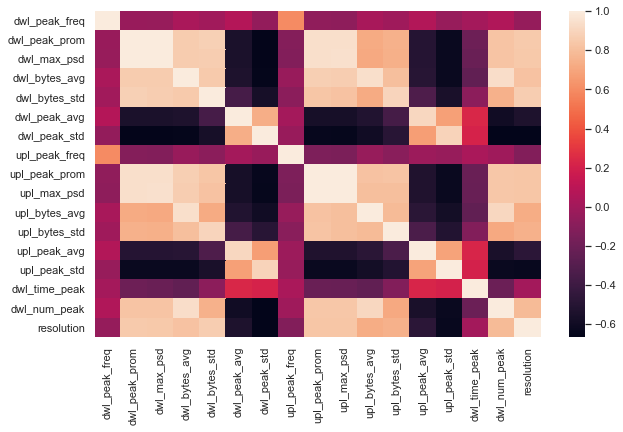

In [27]:
plt.figure(figsize=(10,6))
sns.heatmap(training.corr())

In [28]:
features = training.columns
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]
for i in indices:
    print(features[i],': ',importances[i])

dwl_peak_prom :  0.1633486136407091
dwl_bytes_avg :  0.125892466835434
upl_peak_prom :  0.09581236179781737
upl_max_psd :  0.09048817017375396
dwl_max_psd :  0.08742266790447165
dwl_bytes_std :  0.0865873828930258
dwl_time_peak :  0.08533004562535883
upl_bytes_std :  0.05768418564233141
upl_bytes_avg :  0.05742131582972328
dwl_num_peak :  0.05446492956568444
dwl_peak_avg :  0.02737074445752213
dwl_peak_std :  0.01787582007942848
upl_peak_avg :  0.01651079711302995
upl_peak_std :  0.013664769345696284
upl_peak_freq :  0.011584145248076933
dwl_peak_freq :  0.008541583847936402


In [29]:
corr=training.corr()

columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = training.columns[columns]
#training = training[selected_columns]

In [30]:
np.abs(training.corr()['resolution']).sort_values(ascending=False)

resolution       1.000000
dwl_bytes_std    0.864321
dwl_peak_prom    0.856581
dwl_max_psd      0.845785
upl_peak_prom    0.836102
upl_max_psd      0.831667
dwl_bytes_avg    0.817893
dwl_num_peak     0.785972
upl_bytes_std    0.750479
upl_bytes_avg    0.727499
dwl_peak_std     0.665882
upl_peak_std     0.628925
dwl_peak_avg     0.529568
upl_peak_avg     0.473178
upl_peak_freq    0.117902
dwl_peak_freq    0.041487
dwl_time_peak    0.009630
Name: resolution, dtype: float64

In [ ]:
features = ['dwl_peak_freq','dwl_peak_prom','dwl_max_psd','dwl_bytes_avg','dwl_bytes_std','dwl_peak_avg',
            'dwl_peak_std','upl_peak_freq','upl_peak_prom','upl_max_psd','upl_bytes_avg','upl_bytes_std',
            'upl_peak_avg','upl_peak_std','dwl_time_peak','dwl_num_peak']
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]
for i in indices:
    print(features[i],': ',importances[i])
    

## Reduced feature model

In [34]:
reduce_feats = training[selected_columns]

In [35]:
X, y = reduce_feats.drop(columns=['resolution']), reduce_feats['resolution']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=reduce_feats['resolution'], random_state = 4)

classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)
#classifier = RandomForestClassifier(n_estimators = 100, criterion = 'gini', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [36]:

y_pred = classifier.predict(X_test)
(pd.crosstab(y_test, y_pred, rownames=['Actual Group'], colnames=['Predicted Group']))

Predicted Group,0,1,2,3,4
Actual Group,,,,,
0,9,0,0,0,0
1,0,7,1,2,0
2,0,1,8,0,0
3,0,0,0,7,2
4,0,0,1,1,8


In [37]:
f1_score(y_test, y_pred, average=None)

array([1.        , 0.77777778, 0.84210526, 0.73684211, 0.8       ])

In [38]:
accuracy_score(y_test, y_pred)

0.8297872340425532

## test data

In [39]:
test_fp = '../data/test_data/'

In [40]:
%%time
test_feats_0 = create_features([pd.read_csv(test_fp+'sgs008-109-action-240p-20210202.csv')], 120)
test_feats_1 = create_features([pd.read_csv(test_fp+'sgs008-109-action-360p-20210213.csv')], 120)
test_feats_2 = create_features([pd.read_csv(test_fp+'sgs008-109-action-480p-20210202.csv')], 120)
test_feats_3 = create_features([pd.read_csv(test_fp+'sgs008-109-action-720p-20210213.csv')], 120)
test_feats_4 = create_features([pd.read_csv(test_fp+'sgs008-109-action-1080p-20210202.csv')], 120)

# y_pred = classifier.predict(test_low)
# y_pred

Wall time: 29.5 s


In [56]:
test_feats_0['resolution'] = 0
test_feats_1['resolution'] = 1
test_feats_2['resolution'] = 2
test_feats_3['resolution'] = 3
test_feats_4['resolution'] = 4

test = pd.concat([test_feats_0,test_feats_1,test_feats_2,test_feats_3,test_feats_4]).reset_index(drop=True)
#test=test[selected_columns]

In [57]:
classifier.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [58]:
test_feat, test_actual = test.drop(columns=['resolution']), test['resolution']

In [59]:
test_pred = classifier.predict(test_feat)

In [60]:
(pd.crosstab(test_actual, test_pred, rownames=['Actual Group'], colnames=['Predicted Group']))

Predicted Group,0,1,2,3,4
Actual Group,,,,,
0,15,1,0,0,0
1,0,14,1,0,0
2,0,1,13,1,0
3,0,0,0,5,10
4,1,0,0,1,13


In [61]:
f1_score(test_actual, test_pred, average=None)

array([0.9375    , 0.90322581, 0.89655172, 0.45454545, 0.68421053])

In [62]:
accuracy_score(test_actual, test_pred)

0.7894736842105263

In [ ]:
seven_two_test = pd.read_csv(test_fp+'sgs008-109-action-720p-20210213.csv')
ten_eight_test = pd.read_csv(test_fp+'sgs008-109-action-1080p-20210202.csv')

In [ ]:
y_720 = seven_two_test.groupby('Time')['2->1Bytes'].sum() * (1/125000)
y_1080 = ten_eight_test.groupby('Time')['2->1Bytes'].sum() * (1/125000)

In [ ]:
sns.set_style('whitegrid')
colors = sns.color_palette()
plt.figure(figsize=(18,6))

fig, axes = plt.subplots(2, 1, figsize=(24, 12), sharex=True, sharey=True)

sns.lineplot(y=y_720, x=np.arange(len(y_720)), ax=axes[0], label='720p', color=colors[0])
axes[0].set_title("Andrew - 720p (Action)", fontsize=16)

sns.lineplot(y=y_1080, x=np.arange(len(y_1080)), ax=axes[1], label='1080p', color=colors[1])
axes[1].set_title("Andrew - 1080p (Action)", fontsize=16)

plt.suptitle("Investigating Failed Cases", fontsize=24)
for ax in axes.flat:
    ax.set_xlabel("Seconds (from start)", fontsize=24)
    ax.set_ylabel("Mbps", fontsize=24)
    ax.label_outer()

fig.show();

In [ ]:
preproc_720 = seven_two_test.copy()
preproc_720['resolution'] = '720p'

preproc_1080 = ten_eight_test.copy()
preproc_1080['resolution'] = '1080p'

peaks_720 = preprocess_data_peaks([preproc_720], '2->1Bytes')
peaks_1080 = preprocess_data_peaks([preproc_1080], '2->1Bytes')

combined = pd.concat((peaks_720, peaks_1080))

In [ ]:
plt.figure(figsize=(8, 8))
sns.boxplot(data=combined, x="resolution", y="Mbps", linewidth=2)
plt.suptitle("Peaks - 720p v 1080p", fontsize=24)